In [34]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve


**загрузка данных**

In [35]:
data = pd.read_csv("./data/train.csv", encoding = 'ISO-8859-1', low_memory = False)

**Гистограмма**

<AxesSubplot:>

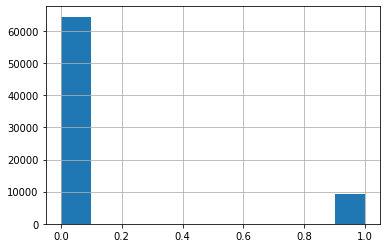

In [36]:
data['default'].hist()

Типы данных, пропуска в данных

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73799 non-null  int64 
 1   education         73492 non-null  object
 2   sex               73799 non-null  object
 3   age               73799 non-null  int64 
 4   car               73799 non-null  object
 5   car_type          73799 non-null  object
 6   decline_app_cnt   73799 non-null  int64 
 7   good_work         73799 non-null  int64 
 8   bki_request_cnt   73799 non-null  int64 
 9   home_address      73799 non-null  int64 
 10  work_address      73799 non-null  int64 
 11  income            73799 non-null  int64 
 12  foreign_passport  73799 non-null  object
 13  default           73799 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 7.9+ MB


In [38]:
data.isna().sum()

client_id             0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
bki_request_cnt       0
home_address          0
work_address          0
income                0
foreign_passport      0
default               0
dtype: int64

<AxesSubplot:>

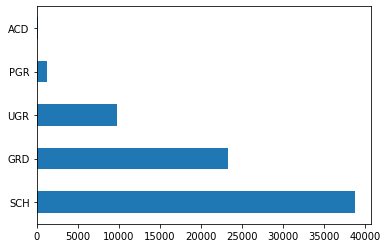

In [39]:
data['education'].value_counts().plot.barh()

**Замена пропусков на самые встречающееся значение**

In [40]:
def replaceValue(data, columns):
    for column in columns:
        max_ = data[column].value_counts().idxmax()
        data[column] = data[column].apply(lambda x: max_ if pd.isnull(x) else ( max_ if (x == 'nan' or x.strip() == '')  else x  ))
    return data
data = replaceValue(data, ['education'])
data.isna().sum()

client_id           0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
bki_request_cnt     0
home_address        0
work_address        0
income              0
foreign_passport    0
default             0
dtype: int64

## Числовые переменные 
Логарифмирование переменных (не всех! )

In [41]:
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
number_log_column = ['age',  'income']
def logNumberValue(data, columns):
    for column in columns:
        data[column] = data[column].apply(lambda w: np.log(w + 1 ))
    return data
data = logNumberValue(data, num_cols)

c:\program files\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


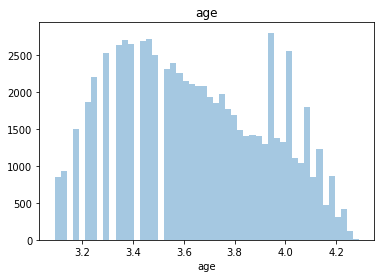

c:\program files\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


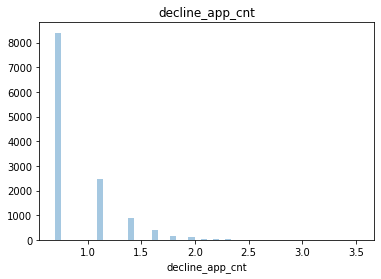

c:\program files\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


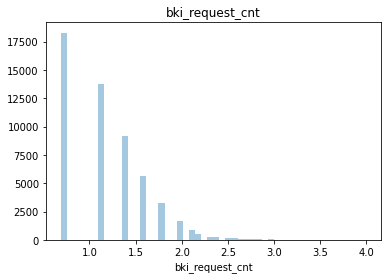

c:\program files\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


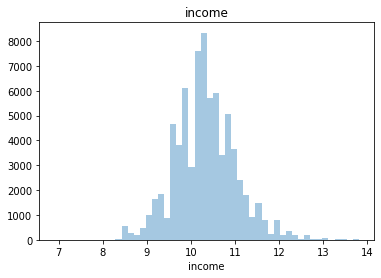

In [42]:
for i in num_cols:
    plt.figure()
    sns.distplot(data[i][data[i] > 0], kde = False, rug=False)
    plt.title(i)
    plt.show()

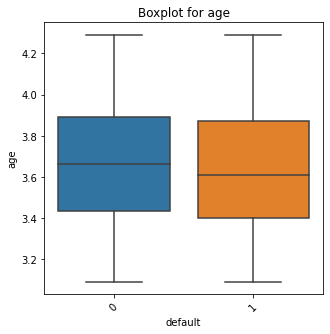

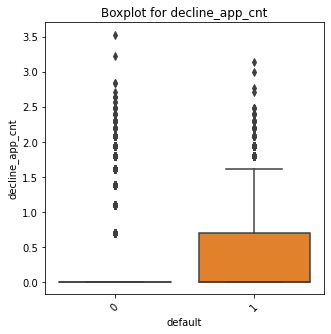

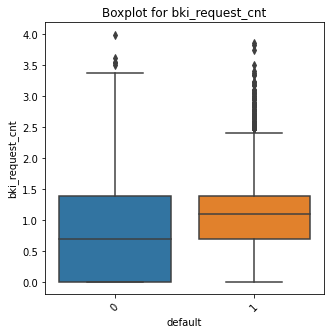

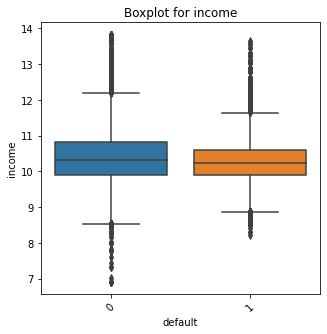

In [43]:
def get_boxplot(date, column):
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.boxplot(x='default', y=data[col], data=data, orient='v', ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

for col in num_cols:
    get_boxplot(data, col)

Корреляция

<AxesSubplot:>

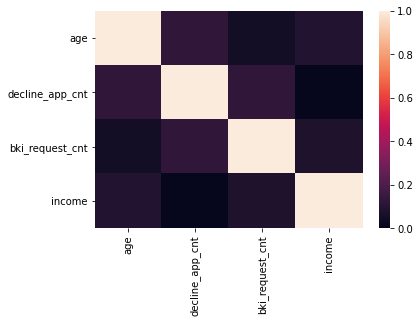

In [44]:
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)

In [45]:
data[num_cols].corr().abs()

,age,decline_app_cnt,bki_request_cnt,income
age,1.000000,0.127734,0.049327,0.092586
decline_app_cnt,0.127734,1.000000,0.125163,0.013868
bki_request_cnt,0.049327,0.125163,1.000000,0.081019
income,0.092586,0.013868,0.081019,1.000000


<AxesSubplot:>

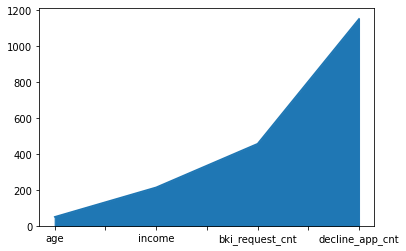

In [46]:
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'area')

### Категориальные переменные

In [49]:
cat_cols =  ['education', 'home_address', 'work_address']
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
label_encoder = LabelEncoder()
for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

In [50]:
X_cat = OneHotEncoder(sparse = False).fit_transform(data[cat_cols].values)
X_num = StandardScaler().fit_transform(data[num_cols].values)
X = np.hstack([X_num, data[bin_cols].values, X_cat])
Y = data['default'].values


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

c:\program files\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


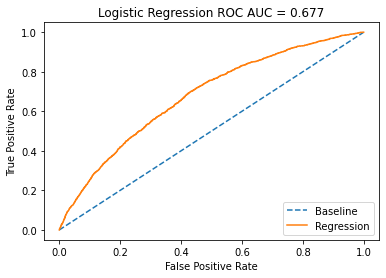

In [52]:
model = LogisticRegression()
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()